In [ ]:
!pip install protobuf~=3.20.3
!pip install -U tensorflow-text tensorflow
!pip install tensorflow_datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NMT-MP-Attention/

Mounted at /content/drive
/content/drive/MyDrive/NMT-MP-Attention


In [ ]:
import os
import logging
import time
import string
import json
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

import transformers

In [ ]:
strip_chars = string.punctuation + "|"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace('""', "")

In [ ]:
vocab_size = 8000
sequence_length = 30
batch_size = 128

In [ ]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
full_vocab = tokenizer.get_vocab()

with open('./hi-en/vectorizers/full_vocab.json', 'r') as f:
  json.dump(vocab, f)

Load the vocabulary

In [ ]:
with open('./hi-en/vectorizers/hin_vocab.json', 'r') as f:
    hin_vocab = json.load(f)
with open('./hi-en/vectorizers/eng_vocab.json', 'r') as f:
    eng_vocab = json.load(f)

Create a TextVectorization layer with the loaded vocabulary

In [ ]:
hin_vectorization = TextVectorization(vocabulary=hin_vocab,output_mode="int", output_sequence_length=sequence_length)
eng_vectorization = TextVectorization(vocabulary=eng_vocab,output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization)

In [ ]:
train_ds = tf.data.experimental.load("./hi-en/tf_dataset/train_ds").prefetch(tf.data.experimental.AUTOTUNE)
test_ds = tf.data.experimental.load("./hi-en/tf_dataset/test_ds").prefetch(tf.data.experimental.AUTOTUNE)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [ ]:
train_batches = tf.data.experimental.load("./hi-en/tf_dataset/train_batches").prefetch(tf.data.experimental.AUTOTUNE)
test_batches = tf.data.experimental.load("./hi-en/tf_dataset/test_batches").prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
for (hin, eng), eng_labels in train_batches.take(1):
  break

In [ ]:
print(hin.shape)
print(eng.shape)
print(eng_labels.shape)

(64, 30)
(64, 30)
(64, 30)


In [ ]:
print(eng[0][:10])
print(eng_labels[0])

tf.Tensor([   3 2940    7   14   13   54 4447    6    1   34], shape=(10,), dtype=int64)
tf.Tensor(
[2940    7   14   13   54 4447    6    1   34  234    9 2940  495   94
  357    7   14   50    2  414    5  357   24 2940    2 1031   34  122
   28  357], shape=(30,), dtype=int64)


In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


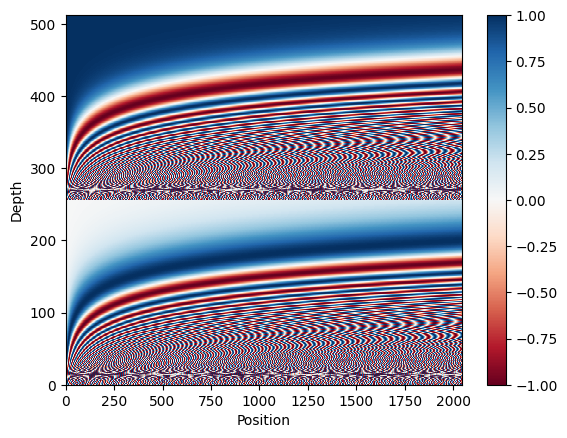

In [ ]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

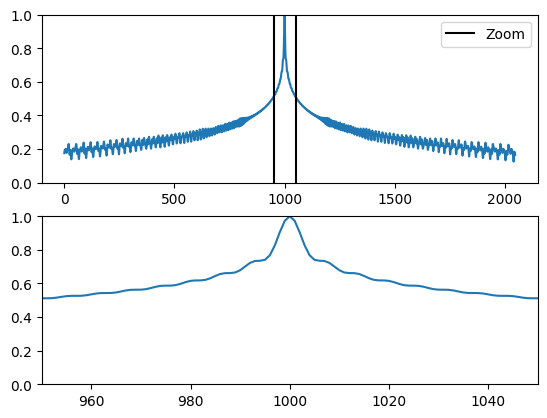

In [ ]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_hin = PositionalEmbedding(vocab_size=len(hin_vocab), d_model=512)
embed_eng = PositionalEmbedding(vocab_size=len(eng_vocab), d_model=512)

hin_emb = embed_hin(hin)
eng_emb = embed_eng(eng)

hin_emb._keras_mask

<tf.Tensor: shape=(64, 30), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ..., False, False, False]])>

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(hin_emb.shape)
print(eng_emb.shape)
print(sample_ca(hin_emb, eng_emb).shape)

(64, 30, 512)
(64, 30, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 30, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(hin_emb.shape)
print(sample_gsa(hin_emb).shape)

(64, 30, 512)
(64, 30, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'global_self_attention' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(eng_emb.shape)
print(sample_csa(eng_emb).shape)

(64, 30, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 30, 512)


In [ ]:
out1 = sample_csa(embed_eng(eng[:, :3]))
out2 = sample_csa(embed_eng(eng))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

7.1525574e-07

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
sample_ffn = FeedForward(512, 2048)

print(hin_emb.shape)
print(sample_ffn(hin_emb).shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'sequential' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 30, 512)
(64, 30, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'feed_forward' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [ ]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(hin_emb.shape)
print(sample_encoder_layer(hin_emb).shape)

(64, 30, 512)
(64, 30, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'global_self_attention_1' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'encoder_layer' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(hin, training=False)

# Print the shape.
print(hin.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'encoder_layer_1' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 30)
(64, 30, 512)


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [ ]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=eng_emb, context=hin_emb)

print(eng_emb.shape)
print(hin_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'causal_self_attention_1' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 30, 512)
(64, 30, 512)
(64, 30, 512)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'decoder_layer' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [ ]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=eng,
    context=hin_emb)

# Print the shapes.
print(eng.shape)
print(hin_emb.shape)
print(output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'decoder_layer_1' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(64, 30)
(64, 30, 512)
(64, 30, 512)


In [ ]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 30, 30])

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(hin_vocab),
    target_vocab_size=len(eng_vocab),
    dropout_rate=dropout_rate)

In [ ]:
output = transformer((hin, eng))

print(hin.shape)
print(eng.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

(64, 30)
(64, 30)
(64, 30, 8000)
(64, 8, 30, 30)


In [ ]:
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)                  │ ?                           │       3,662,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_1 (Decoder)                  │ ?                           │       5,773,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ ?                           │       1,032,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,468,672 (39.93 MB)

 Trainable params: 10,468,672 (39.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
    'd_model': self.d_model,
    'warmup_steps': self.warmup_steps,
     }
    return config

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

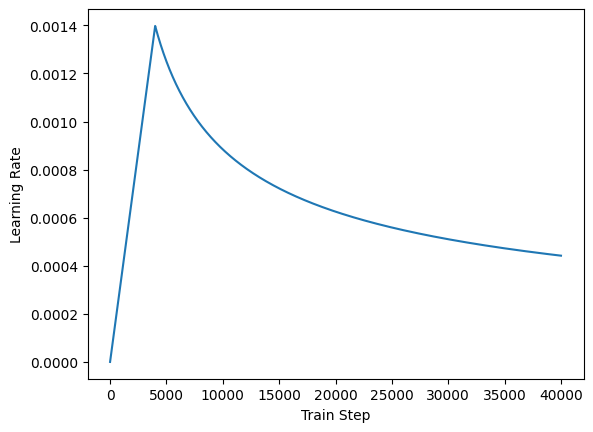

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [ ]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
checkpoint_filepath = './hi-en/ckpt/checkpoint.model.keras'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_masked_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
csv_logger = callbacks.CSVLogger('./hi-en/training_log.csv' , append=True)

In [ ]:
backup_callback = callbacks.BackupAndRestore(backup_dir="./hi-en/backup" ,
                                             delete_checkpoint=False)

In [ ]:
epochs = 30
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [ ]:
history = transformer.fit(train_batches,
                epochs=epochs,
                validation_data=test_batches,
                callbacks=[
                      early_stopping ,
                      model_checkpoint_callback ,
                      csv_logger ,
                      backup_callback ])

Epoch 1/30
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 336s 107ms/step - loss: 6.5982 - masked_accuracy: 0.1607 - val_loss: 4.3671 - val_masked_accuracy: 0.2970
Epoch 2/30
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 233s 89ms/step - loss: 4.2228 - masked_accuracy: 0.3010 - val_loss: 3.5271 - val_masked_accuracy: 0.3755
Epoch 3/30
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 223s 89ms/step - loss: 3.5659 - masked_accuracy: 0.3629 - val_loss: 3.0904 - val_masked_accuracy: 0.4248
Epoch 4/30
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 225s 90ms/step - loss: 3.2051 - masked_accuracy: 0.4030 - val_loss: 2.8782 - val_masked_accuracy: 0.4503
Epoch 5/30
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 222s 89ms/step - loss: 2.9928 - masked_accuracy: 0.4298 - val_loss: 2.7500 - val_masked_accuracy: 0.4674
Epoch 6/30
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 224s 90ms/step - loss: 2.8433 - masked_accuracy: 0.4500 - val_loss: 2.6368 - val_masked_accuracy: 0.4818
Epoch 7/30
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 261s 105ms/step - loss: 2.7262 - masked_accuracy: 0.4663 - val_loss: 2.5496

In [ ]:
transformer.save('./hi-en/final-model-2_hi-en.keras')

In [ ]:
transformer.load_weights('./hi-en/backup/latest.weights.h5')

Plots saved as './hi-en/trainloss.png'


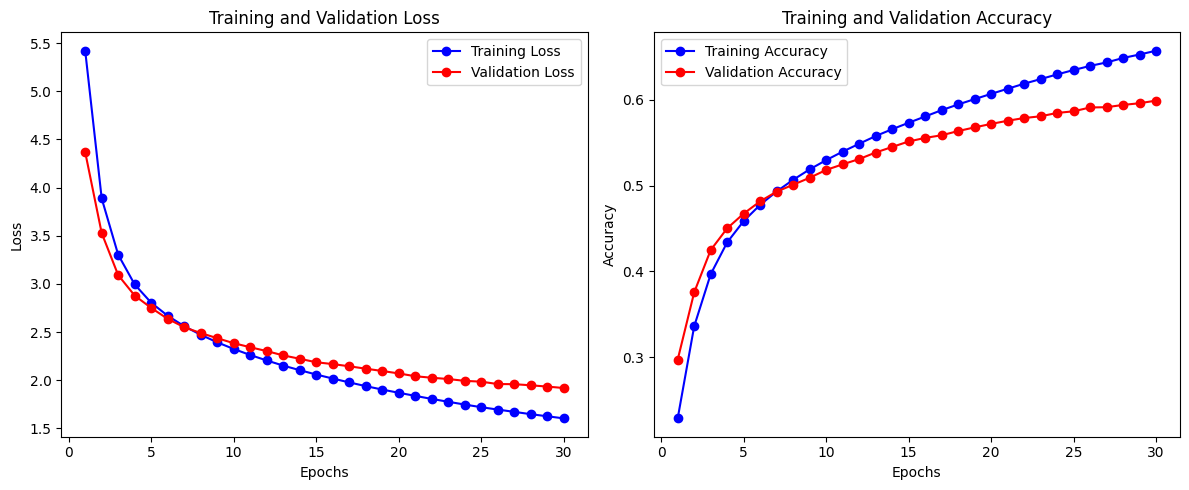

In [ ]:
def plot_loss_and_accuracy(history, save_dir=None, filename=None):
    # Extract the loss and accuracy values from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    masked_accuracy = history.history['masked_accuracy']
    val_masked_accuracy = history.history['val_masked_accuracy']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, masked_accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_masked_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    # Save the figure if save_dir and filename are provided
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path)
        print(f"Plots saved as '{save_path}'")
    plt.show()

plot_loss_and_accuracy(history ,"./hi-en/", "trainloss.png")

In [ ]:
MAX_TOKENS=30
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
class Translator(tf.Module):
  def __init__(self, hin_vectorization, mar_vectorization, eng_vocab, transformer):
    self.hin_vectorization = hin_vectorization
    self.eng_vectorization = eng_vectorization
    self.eng_vocab = eng_vocab
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Hindi, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = hin_vectorization([sentence])

    encoder_input = sentence

    # As the output language is Marathi, initialize the output with the
    # English `[START]` token.
    start_end = eng_vectorization([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    # text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.
    # vocab = mar_vectorization.get_vocabulary()

    text = " ".join([eng_vocab[each.numpy().astype(np.int32)] for each in tf.squeeze(predictions)])

    # mar_index_lookup = dict(zip(range(len(mar_vocab)), mar_vocab))
    # sampled_token_index = np.argmax(predictions[0, i, :])
    # tokens = mar_index_lookup[sampled_token_index]

    # tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, attention_weights

In [ ]:
translator = Translator(hin_vectorization, eng_vectorization, eng_vocab, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = 'उन्होंने कारगिल युद्ध में हिस्सा लिया था।'
ground_truth = 'He took part in the Kargil war'

translated_text, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Input:         : उन्होंने कारगिल युद्ध में हिस्सा लिया था।
Prediction     : 1911 [end] [UNK] 1911 in  in and the absurd 1909 60000  [end] 60000 [start] 1911 [end] in of  that 1909 [start] of [UNK] the [start] [UNK] of [start]  [end] [start] of absurd and of absurd the 60000 of [end] of the  [UNK] [end]  1909 to 1911 the abul  to 1909 the to of [end] [UNK] [start] [end]  [UNK] 60000 [start] in a in 1911  1909 the  [UNK] [UNK] [start]   and 1911 in [start] of 1909 of the  the  of [start] the of 1911 and  the of the the 1909 [end] of [end] [start] [end] in in the [start] is of [end] to [end] to 1909 [start]   the  [start] to 1909 the 1909 the [end] the [UNK] [start] [end] the a and the  the and and [start] 1909 the a the to and the [start] and 1909 of  in the in  and [end] [start] absurd of the [end] [UNK] of [start] [end]  [start] in  the and  [UNK] the [end] [end] [start]  [UNK] [end] [end] the [UNK] the  the [end] of  is the the  [UNK] and [start] of of [start] and  1909 [start] [end] 

In [ ]:
sentence = 'राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है'
ground_truth = 'politicians do not have permission to do what needs to be done.'

translated_text, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:857: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

Input:         : राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है
Prediction     : absurd in in absurd for in is is on [start] in that for to to a [start] in [start] [UNK] [UNK] in [start] [end] a it a in and in is and and in [end] [end] [start] to [UNK] of to is of is of  of [UNK] [end] of to of 1909 alia [end] and and in [end]  in of in to [start] the [start] and to in in 1911 [start] [UNK] [UNK] in and [UNK] 1911 the  and 1909 [end] [UNK] [UNK] 1909 a [start] [start] [start] [UNK] of in [UNK] [start] [end] the [UNK] of in [end]  the [end] and  in the of and [UNK] of of to it in the and [end] [start] of  [UNK] [start] the in  [UNK]  [start] and in the  [start] [UNK] in of [UNK]  [end] [UNK] and  1911 [start] [start]  the [end] [end] [start] [start] the of 1911 in in  [start] 1909 [start] [UNK] 1911 [end] the [UNK] [end] of 60000 [start] and  in in  in the [UNK]  [UNK]  [end] [end] [UNK] 1909  the [UNK]  of  [end] [end]  of 1909 the [UNK] [end] [end]  the the the [en

In [ ]:
sentence = 'इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।'
ground_truth = 'politicians do not have permission to do what needs to be done.'

translated_text, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Input:         : इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
Prediction     : bastar the  bastar [UNK] 1909  1909 1909 60000 1909 absurd 60000 1909 absurd 1909 abul abul absurd absurd absurd 1909 absurd ailment 60000 1911 accounted absurd 60000 1911 1911 1909 1911 1909 absurd 1909 absurd 60000 ailment alia abul ailment 60000 abul 60000 ailment abul abul abul 1911 60000 accounted abul ailment absurd absurd accounted  ailment abul abul accounted 1911 1911 ailment absurd ailment 60000 alia 60000 ailment 60000 alia accounted accounted ailment abul 1911 abul ailment accounted accounted accounted abul 60000 1909 alia accounted absurd accounted abul accounted abul ailment abul abul accounted 1909 accounted absurd absurd 60000 accounted absurd abul accounted absurd abul ailment abul absurd 60000 1911 accounted 1911 abul ailment absurd accounted alia 60000 ailment ailment alia absurd accounted absurd alia absurd ally ailment 60000 accounted accounted accounted alia accounted alia ailment aligar